In [ ]:
!pip install transformers torch tqdm scikit-learn pandas


In [ ]:
# ============================================
# 1. IMPORT THƯ VIỆN
# ============================================
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, DistilBertForSequenceClassification
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, f1_score, classification_report
from tqdm import tqdm


In [ ]:
# ============================================
# 2. TẢI DỮ LIỆU & TIỀN XỬ LÝ
# ============================================
df = pd.read_csv("/content/WELFake_Dataset.csv")

# Xoá cột thừa và xử lý giá trị thiếu
df = df.drop(columns=['Unnamed: 0'], errors='ignore')
df = df.fillna('')
df['text'] = df['title'] + " " + df['text']

# Chuẩn bị dữ liệu đầu vào
X = df["text"].tolist()
y = df["label"].astype(int).tolist()

print("Tổng số mẫu:", len(df))
df.head()


Tổng số mẫu: 72134


,title,text,label
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,1
1,,Did they post their votes for Hillary already?,1
2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,1
3,"Bobby Jindal, raised Hindu, uses story of Chri...","Bobby Jindal, raised Hindu, uses story of Chri...",0
4,SATAN 2: Russia unvelis an image of its terrif...,SATAN 2: Russia unvelis an image of its terrif...,1


In [ ]:

# ============================================
# 3. TOKENIZER
# ============================================
MODEL_NAME = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
MAX_LEN = 128

# Dataset cho PyTorch
class FakeNewsDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_tensors="pt",
        )
        return {
            "input_ids": encoding["input_ids"].squeeze(),
            "attention_mask": encoding["attention_mask"].squeeze(),
            "label": torch.tensor(label, dtype=torch.long),
        }


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
# ============================================
# 4. KIỂM TRA CHÉO (K-FOLD CROSS VALIDATION)
# ============================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Thiết bị sử dụng:", device)

kf = KFold(n_splits=3, shuffle=True, random_state=42)
accuracies = []
f1_scores = []


EPOCHS = 5
BATCH_SIZE = 16


Thiết bị sử dụng: cuda


In [ ]:
fold = 1

for train_index, val_index in kf.split(X):
    print(f"\n===== Fold {fold} =====")

    # Chia dữ liệu
    X_train_fold = [X[i] for i in train_index]
    y_train_fold = [y[i] for i in train_index]
    X_val_fold = [X[i] for i in val_index]
    y_val_fold = [y[i] for i in val_index]

    # Dataset & Dataloader
    train_dataset = FakeNewsDataset(X_train_fold, y_train_fold, tokenizer, MAX_LEN)
    val_dataset = FakeNewsDataset(X_val_fold, y_val_fold, tokenizer, MAX_LEN)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

    # Mô hình mới cho mỗi fold
    model = DistilBertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)
    model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)

    # --- Huấn luyện ---
    for epoch in range(EPOCHS):
        model.train()
        total_loss = 0
        loop = tqdm(train_loader, desc=f"Fold {fold} | Epoch {epoch+1}", leave=False)
        for batch in loop:
            optimizer.zero_grad()
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            loop.set_postfix(loss=loss.item())

        print(f"Epoch {epoch+1} | Average training loss: {total_loss / len(train_loader):.4f}")

    # --- Đánh giá ---
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for batch in tqdm(val_loader, desc=f"Đánh giá Fold {fold}"):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            preds = torch.argmax(outputs.logits, dim=-1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average="weighted")
    accuracies.append(acc)
    f1_scores.append(f1)

    print(f"\nFold {fold} | Accuracy: {acc:.4f} | Weighted F1: {f1:.4f}")
    print(classification_report(y_true, y_pred, digits=4))

    fold += 1



===== Fold 1 =====


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1 | Average training loss: 0.0528


Epoch 2 | Average training loss: 0.0160


Epoch 3 | Average training loss: 0.0065


Epoch 4 | Average training loss: 0.0051


Epoch 5 | Average training loss: 0.0037


Đánh giá Fold 1: 100%|██████████| 1503/1503 [02:07<00:00, 11.80it/s]



Fold 1 | Accuracy: 0.9932 | Weighted F1: 0.9932
              precision    recall  f1-score   support

           0     0.9919    0.9942    0.9930     11775
           1     0.9944    0.9922    0.9933     12270

    accuracy                         0.9932     24045
   macro avg     0.9932    0.9932    0.9932     24045
weighted avg     0.9932    0.9932    0.9932     24045


===== Fold 2 =====


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1 | Average training loss: 0.0533


Epoch 2 | Average training loss: 0.0159


Epoch 3 | Average training loss: 0.0082


Epoch 4 | Average training loss: 0.0045


Epoch 5 | Average training loss: 0.0034


Đánh giá Fold 2: 100%|██████████| 1503/1503 [02:06<00:00, 11.85it/s]



Fold 2 | Accuracy: 0.9929 | Weighted F1: 0.9929
              precision    recall  f1-score   support

           0     0.9911    0.9943    0.9927     11609
           1     0.9947    0.9916    0.9932     12436

    accuracy                         0.9929     24045
   macro avg     0.9929    0.9930    0.9929     24045
weighted avg     0.9929    0.9929    0.9929     24045


===== Fold 3 =====


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1 | Average training loss: 0.0556


Epoch 2 | Average training loss: 0.0158


Epoch 3 | Average training loss: 0.0074


Epoch 4 | Average training loss: 0.0049


Epoch 5 | Average training loss: 0.0029


Đánh giá Fold 3: 100%|██████████| 1503/1503 [02:05<00:00, 11.95it/s]



Fold 3 | Accuracy: 0.9927 | Weighted F1: 0.9927
              precision    recall  f1-score   support

           0     0.9927    0.9922    0.9924     11644
           1     0.9927    0.9931    0.9929     12400

    accuracy                         0.9927     24044
   macro avg     0.9927    0.9927    0.9927     24044
weighted avg     0.9927    0.9927    0.9927     24044



In [ ]:
# ============================================
# 5. TỔNG KẾT KẾT QUẢ
# ============================================
print("\n===== KẾT QUẢ TRUNG BÌNH SAU KIỂM TRA CHÉO =====")
print(f"Average Accuracy: {sum(accuracies)/len(accuracies):.4f}")
print(f"Average Weighted F1: {sum(f1_scores)/len(f1_scores):.4f}")



===== KẾT QUẢ TRUNG BÌNH SAU KIỂM TRA CHÉO =====
Average Accuracy: 0.9929
Average Weighted F1: 0.9929


- Mô hình DistilBERT, dù nhỏ gọn (~66M tham số, nhẹ hơn BERT-base gần 40%), vẫn đạt hiệu suất gần như hoàn hảo trên tập dữ liệu này.

- Độ chênh lệch giữa các fold rất thấp (<0.3%), chứng tỏ dữ liệu huấn luyện đồng đều và ổn định.

- Các giá trị Precision và Recall gần bằng nhau → mô hình không bị lệch về một lớp nào (balanced prediction).

- Loss giảm đều qua mỗi epoch, chứng tỏ học tốt mà không overfit.

# tinh chỉnh siêu tham số

In [ ]:
BEST_LR = 2e-5
BEST_BATCH_SIZE = 16

BEST_EPOCHS = 5


In [ ]:


# ============================================
# 6. TINH CHỈNH VÀ LƯU MÔ HÌNH CUỐI CÙNG
# (Sử dụng siêu tham số tốt nhất từ K-Fold)
# ============================================
from sklearn.model_selection import train_test_split

# Chia dữ liệu thành tập train/val
# Lưu ý: Tập Val (20%) này chỉ dùng để kiểm tra lần cuối, không dùng để chọn siêu tham số.
X_train_final, X_val_final, y_train_final, y_val_final = train_test_split(X, y, test_size=0.2, random_state=42)

# Dataset & Dataloader cho việc tinh chỉnh cuối
train_dataset_final = FakeNewsDataset(X_train_final, y_train_final, tokenizer, MAX_LEN)
val_dataset_final = FakeNewsDataset(X_val_final, y_val_final, tokenizer, MAX_LEN)

train_loader_final = DataLoader(train_dataset_final, batch_size=BEST_BATCH_SIZE, shuffle=True)
val_loader_final = DataLoader(val_dataset_final, batch_size=BEST_BATCH_SIZE, shuffle=False)

# Khởi tạo lại mô hình mới
print("\n===== Bắt đầu Tinh chỉnh Lần cuối (Finetuning) =====")
model = DistilBertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)
model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=BEST_LR)

# --- Vòng lặp Huấn luyện Cuối cùng ---
for epoch in range(BEST_EPOCHS):
    model.train()
    total_loss = 0
    loop = tqdm(train_loader_final, desc=f"Final Finetune | Epoch {epoch+1}", leave=False)
    for batch in loop:
        optimizer.zero_grad()
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        # Forward pass
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss

        # Backward pass và cập nhật trọng số
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        loop.set_postfix(loss=loss.item())

    print(f"Epoch {epoch+1} | Average training loss: {total_loss / len(train_loader_final):.4f}")



===== Bắt đầu Tinh chỉnh Lần cuối (Finetuning) =====


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1 | Average training loss: 0.0469


Epoch 2 | Average training loss: 0.0135


Epoch 3 | Average training loss: 0.0066


Epoch 4 | Average training loss: 0.0043


Epoch 5 | Average training loss: 0.0036


In [ ]:

# --- Đánh giá lần cuối trên tập Val (20%) ---
print("\n===== Đánh giá trên tập Validation cuối cùng =====")
model.eval()
y_true_final, y_pred_final = [], []
with torch.no_grad():
    for batch in tqdm(val_loader_final, desc="Đánh giá Cuối cùng"):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=-1)
        y_true_final.extend(labels.cpu().numpy())
        y_pred_final.extend(preds.cpu().numpy())

acc_final = accuracy_score(y_true_final, y_pred_final)
f1_final = f1_score(y_true_final, y_pred_final, average="weighted")

print(f"Final Validation Accuracy: {acc_final:.4f} | Final Weighted F1: {f1_final:.4f}")
print(classification_report(y_true_final, y_pred_final, digits=4))




===== Đánh giá trên tập Validation cuối cùng =====


Đánh giá Cuối cùng: 100%|██████████| 902/902 [01:38<00:00,  9.16it/s]


Final Validation Accuracy: 0.9925 | Final Weighted F1: 0.9925
              precision    recall  f1-score   support

           0     0.9959    0.9889    0.9924      7089
           1     0.9893    0.9960    0.9927      7338

    accuracy                         0.9925     14427
   macro avg     0.9926    0.9925    0.9925     14427
weighted avg     0.9925    0.9925    0.9925     14427



<Figure size 600x600 with 0 Axes>

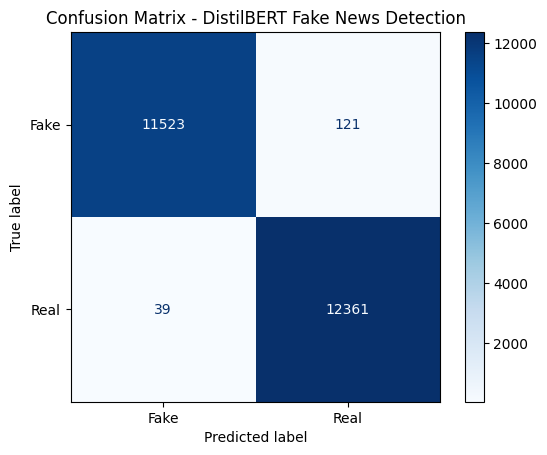

In [ ]:
# ============================================
# HIỂN THỊ MA TRẬN NHẦM LẪN
# ============================================
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Tính ma trận nhầm lẫn
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Fake", "Real"])

plt.figure(figsize=(6, 6))
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix - DistilBERT Fake News Detection")
plt.show()


In [ ]:

# --- Lưu Mô hình ---
# Lưu state_dict (dùng cho PyTorch native load)
torch.save(model.state_dict(), "best_distilbert_model_5epoch.pt")

# Lưu mô hình và tokenizer (dùng cho Hugging Face load)
model.save_pretrained("finetuned_distilbert_fake_news")
tokenizer.save_pretrained("finetuned_distilbert_fake_news")
print("✅ Mô hình đã tinh chỉnh và lưu thành công vào thư mục 'finetuned_distilbert_fake_news'!")

✅ Mô hình đã tinh chỉnh và lưu thành công vào thư mục 'finetuned_distilbert_fake_news'!
